## Identifying Duplicate Questions: Using TF-IDF

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [5]:
import pandas as pd
import numpy as np
import re
import pprint

from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('./res/data/train.csv')

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Self-Briefing

- The point of this is project is to evaluate relationships between word meanings (not necessarily similarities between word meanings themselves).

The word embeddings can be summarized in the following pipeline:
- Read the text
- Preprocess text
- Create (x, y) data points
- Create one hot encoded (x, y) matrices
- Train a neural network
- Extract the weights from the input layer

### Goals
- Find the meaning in each sentence
- Compare meaning between 2 sentences
- Present the comparison in numerical terms
- Define a threshold for determining sufficient similarity

### Exploration

#### Shape, data types, null values

In [8]:
print(df.shape)
print(df.dtypes)
print(type(df['question1'][0])) # object type is pandas series; values are strings

(404290, 6)
id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object
<class 'str'>


In [9]:
print(df.isnull().sum())
print(df[df['question1'].isnull() == True])
print(df[df['question2'].isnull() == True])

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64
            id    qid1    qid2 question1  \
363362  363362  493340  493341       NaN   

                                                question2  is_duplicate  
363362  My Chinese name is Haichao Yu. What English na...             0  
            id    qid1    qid2                         question1 question2  \
105780  105780  174363  174364    How can I develop android app?       NaN   
201841  201841  303951  174364  How can I create an Android app?       NaN   

        is_duplicate  
105780             0  
201841             0  


In [10]:
df.dropna(inplace=True)
print(df.isnull().sum())
print(df.shape)

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64
(404287, 6)


**Shape** is: (404290, 6) before dropped rows \
**Nulls**: Not many. Not sure what those null values are supposed to represent. Perhaps they weren't properly labelled. Dropped.

#### Column analysis

In [11]:
# id is a copy of the index
sum(df.index == df['id'])

404287

In [12]:
# just confirming that the ids are not intermittently sequenced between q1 and q2
len((df['qid1'] - df['qid2']).unique())

157337

In [13]:
# just looking for simple patters in how the questions were separated
print(len(df['question1'].unique()))
print(len(df['question2'].unique()))
print(len(df['question1'].unique()) + len(df['question2'].unique()))

290455
299173
589628


In [14]:
print(df.duplicated(subset=('question1', 'question2')).sum())

0


Looking for class imbalance

In [15]:
df[df['is_duplicate'] == 1].value_counts().sum() / df['is_duplicate'].value_counts().sum()

0.3692005926482919

Samples of questions that were classified as duplicates

In [16]:
df[df['is_duplicate'] == 1].head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


Finding specific phrases or codes

In [17]:
df[df[['question2', 'question2']].apply(
    lambda x: x.str.contains('\[*\]', regex=True)
    ).any(axis=1)].head(10)

,id,qid1,qid2,question1,question2,is_duplicate
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
362,362,722,723,How do I find the zeros of the polynomial func...,How would you find the zero of the function fo...,0
764,764,1523,1524,What is [math]x[/math] if [math]x+\left(\dfrac...,What is [math]\mathop {\lim}\limits_{x \to 0^+...,0
1275,1275,2542,2543,How do I integrate [math]v^3(a^2-v^2)^{\frac{1...,How do I integrate [math]\frac{x^2}{x^2-1}[/ma...,0
1357,1357,2705,2706,How do I get my company's website on the first...,How do I get my website on the first page on G...,0
1478,1478,2943,2944,Why is the European society ignoring the slaug...,[Late 2015 / Early 2016] Why does the United K...,0
1686,1686,3357,3358,"Now that Britain has voted to leave the EU, wh...",[Before Brexit vote] What are the pros and con...,0
1923,1923,3827,3828,Given that alpha and beta are roots of the equ...,The roots of the equation [math]x^2+3x-10=0[/m...,0
2437,2437,4843,4844,Why do not photons obey E = m c ^ 2?,How can photons have no mass and yet still hav...,0
2712,2712,5385,5386,What is [math]\sqrt {2+\sqrt {2+\sqrt {2+\sqrt...,If [math]y=f(x)=\sqrt{x+\sqrt{x^2+\sqrt{x+\sqr...,0


Specific queries

In [18]:
df.loc[1275, 'question1']

'How do I integrate [math]v^3(a^2-v^2)^{\\frac{1}{2}}[/math] by substitution?'

- The `id` column is a copy of the `index`
- The questions are not intermittently sequenced.
- The questions also do not have any obvious patterns.
- Class imbalance is fine.
- Quick perusal of samples suggests that there may be a need to specify numbers (404 errors, numerical codes, etc.)

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

Make a translation table and translate. The first two parameters describe:
1. Text to replace (required)
2. Replacement text (optional)
- Note that 1 and 2 must be of the same length.
- The replacement is performed character for character.

The third parameter allows for removal of characters given the string of characters passed.

In our case, we're not replacing any strings so the first two parameters are blanked. We are, however, removing punctuation so we'll pass the characters in `string.punctuation` to remove them.

#### Pipeline: Split into words, remove punctuation, filter stop words, lemmatize

In [19]:
def lemmatize(text:str) -> str:
    from nltk.stem import WordNetLemmatizer
    
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word, 'n') for word in text]
    text = [lem.lemmatize(word, 'v') for word in text]
    text = [lem.lemmatize(word, 'a') for word in text]
    text = [lem.lemmatize(word, 'r') for word in text]
    text = [lem.lemmatize(word, 's') for word in text]
    
    return text


In [20]:
# define the cleaning pipeline
# this function will be applied to each sentence

def preprocess(text:str) -> str:
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    
    # tokenize words with additional punctiation exceptions
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
            #  if word.replace('.', '', 1).isalnum() | word.replace('/', '', 1).isalnum() | word.replace('-', '', 1).isalnum()]
    
    # lowercase
    words = [word.lower() for word in words]
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    
    # lemmatize
    words = lemmatize(words)
    
    # remove single characters
    words = [word for word in words if len(word) > 1]
        
    return ' '.join(words)

NOTES

1. I had a choice to return only unique values (removing duplicates per `question` value), but I decided against it. The meaning of the question may be better defined by assuming that repeated non-stopwords are more important to the meaning of the question than those that are not repeated.
2. There are numerical codes that may be relevant. I've allowed numerical values that are floats, em-dashed, and fractional.
3. There are many questions formatted with `[math]`. I'm unfamiliar with Quora syntax so I can't presume to know what this syntax indicates. If I were to guess, it encloses a LaTex-formatted strings.
4. To get better results, it may be better to mark anything between 'math' tags as a negative contribution to the comparison.

#### Example Queries

In [21]:
word_tokenize(df.loc[1275, 'question1']) 

['How',
 'do',
 'I',
 'integrate',
 '[',
 'math',
 ']',
 'v^3',
 '(',
 'a^2-v^2',
 ')',
 '^',
 '{',
 '\\frac',
 '{',
 '1',
 '}',
 '{',
 '2',
 '}',
 '}',
 '[',
 '/math',
 ']',
 'by',
 'substitution',
 '?']

In [22]:
preprocess(df['question1'][1275])

'integrate math substitution'

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

One way to tackle this problem is to maybe join both question  columns and then vectorize with the answers. Then it's easy to fit to a label.

In [23]:
clean1 = []
for question in df['question1']:
    clean1.append(preprocess(question))
    
df['clean_q1'] = clean1

In [24]:
clean2 = []
for question in df['question2']:
    clean2.append(preprocess(question))
    
df['clean_q2'] = clean2

In [25]:
df['cleans'] = df['clean_q1'] + ' ' + df['clean_q2']

This results in a single column of combined query terms.

### Word embedding

##### TF-IDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df=5,
    # max_df=0.80,
    # ngram_range=(2,2)
)

tfidf.fit(df['cleans'])
vectors_idf = tfidf.transform(df['cleans'])

In [27]:
tfidf.vocabulary_

{'step': 16648,
 'guide': 7355,
 'invest': 8878,
 'share': 15764,
 'market': 10562,
 'india': 8484,
 'story': 16710,
 'kohinoor': 9587,
 'diamond': 4749,
 'would': 19304,
 'happen': 7506,
 'indian': 8485,
 'government': 7189,
 'steal': 16637,
 'back': 1434,
 'increase': 8457,
 'speed': 16420,
 'internet': 8794,
 'connection': 3656,
 'use': 18484,
 'vpn': 18897,
 'hack': 7407,
 'dns': 5041,
 'mentally': 10849,
 'lonely': 10165,
 'solve': 16277,
 'find': 6394,
 'remainder': 14620,
 'math': 10645,
 'divide': 5008,
 'one': 12293,
 'dissolve': 4971,
 'water': 19000,
 'sugar': 16903,
 'salt': 15262,
 'methane': 10912,
 'carbon': 2620,
 'di': 4731,
 'oxide': 12578,
 'fish': 6425,
 'survive': 17025,
 'astrology': 1175,
 'capricorn': 2603,
 'sun': 16931,
 'cap': 2582,
 'moon': 11303,
 'rise': 14945,
 'say': 15377,
 'triple': 17912,
 'ascendant': 1079,
 'buy': 2444,
 'keep': 9405,
 'active': 178,
 'far': 6195,
 'phone': 13098,
 'video': 18719,
 'game': 6832,
 'good': 7153,
 'geologist': 6974,
 '

##### Word2Vec

In [28]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')
vectors_w2v = df['cleans']

### Train/Test Selection

In [29]:
dy = df['is_duplicate']
dx = vectors_idf

Setting aside about 30% of the training set for validation later.

In [30]:
xtrain, xtest, ytrain, ytest = train_test_split(dx, dy, test_size=0.50, stratify=dy)

In [31]:
xtrain.shape

(202143, 19549)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(xtrain, ytrain)

ypred_lr = lr.predict(xtest)

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(xtrain, ytrain)

ypred_xg = xg.predict(xtest)

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:45:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
nb.fit(xtrain, ytrain)

ypred_nb = nb.predict(xtest)

In [35]:
from tensorflow.keras import Sequential, losses, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Input

In [36]:
model = Sequential()
model.add(LSTM(1024, activation='relu', recurrent_activation='sigmoid'))
model.add(Dense(len(tfidf.vocabulary_)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [37]:
history = model.fit(xtrain.toarray(), ytrain,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    validation_data=(xtest, ytest),)

Epoch 1/50


2022-06-03 18:46:13.622514: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).
    
    Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 19549)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 19549), dtype=float32)
      • training=True
      • mask=None


### Evaluation

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(classification_report(ytest, ypred_lr))
print(classification_report(ytest, ypred_xg))
print(classification_report(ytest, ypred_nb))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81    127512
           1       0.70      0.52      0.60     74632

    accuracy                           0.74    202144
   macro avg       0.73      0.69      0.70    202144
weighted avg       0.74      0.74      0.73    202144

              precision    recall  f1-score   support

           0       0.73      0.93      0.82    127512
           1       0.77      0.40      0.52     74632

    accuracy                           0.73    202144
   macro avg       0.75      0.66      0.67    202144
weighted avg       0.74      0.73      0.71    202144

              precision    recall  f1-score   support

           0       0.80      0.75      0.77    127512
           1       0.61      0.69      0.65     74632

    accuracy                           0.72    202144
   macro avg       0.71      0.72      0.71    202144
weighted avg       0.73      0.72      0.73    202144



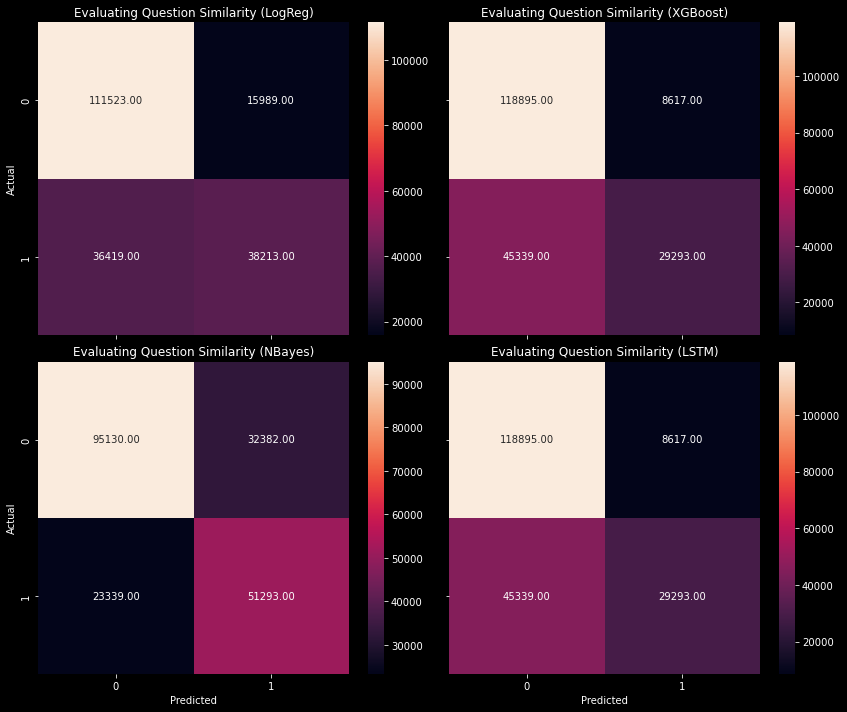

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12, 10), sharex='all', sharey='all')

sns.heatmap(confusion_matrix(ytest,ypred_lr), annot=True, fmt='.2f', ax=ax0)
sns.heatmap(confusion_matrix(ytest,ypred_xg), annot=True, fmt='.2f', ax=ax1)
sns.heatmap(confusion_matrix(ytest,ypred_nb), annot=True, fmt='.2f', ax=ax2)
sns.heatmap(confusion_matrix(ytest,ypred_xg), annot=True, fmt='.2f', ax=ax3)

ax0.set(title="Evaluating Question Similarity (LogReg)",
      # xlabel="Predicted",
      ylabel="Actual",
      )

ax1.set(title="Evaluating Question Similarity (XGBoost)",
      # xlabel="Predicted",
      # ylabel="Actual",
      )

ax2.set(title="Evaluating Question Similarity (NBayes)",
      xlabel="Predicted",
      ylabel="Actual",
      )

ax3.set(title="Evaluating Question Similarity (LSTM)",
      xlabel="Predicted",
      # ylabel="Actual",
      )
 
plt.tight_layout()
plt.show()